In [82]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
def sghmc(U_grad, theta_init, M, C, V_hat, epsilon, T, m):
    """
    Stochastic Gradient Hamiltonian Monte Carlo Sampling.
    Based on Chen, Tianqi, Emily Fox, and Carlos Guestrin (2014)
    --------------------
    
    Dimensions
    -----------
    d: number of parameters
    T: length of samples
    
    Input
    ------
    U_grad: callable 
        Stochastic gradient estimates of posterior density with respect to distribution parameters 
        'U_grad_tilde(D, logp_data_grad, logp_prior_grad, mb_size, theta)' when the gradient is unknown
    
    theta_init: d-by-1 np array
        The inital sampling point
        
    M: d-by-d np array
        A mass matrix
    
    C: d-by-d np array
        A user specified friction term, should be greater than B_hat = 0.5*epsilon*V_hat 
        in the sense of in the sense of positive semi-definiteness
    
    V_hat: d-by-d np array
        Empirical Fisher information of theta
        
    epsilon: float
        Step size
    
    T: int
        Number of samples drawn from the desired distribution
        
    m: int
        Number of steps for each draw
    
    
    Output
    ------
    theta_s: T-by-d np array
        Draws sampled from the desired distrition
    
    r_s: T-by-d np array
        Draws of the momentun variables
    
    """
    d = len(theta_init)
    theta_s = np.zeros((T, d))
    r_s = np.zeros((T, d))
    theta_s[0] = theta_init
    M_inv = np.linalg.inv(M)
    B_hat = 0.5*epsilon*V_hat
    
    if d > 1:
        sd = np.linalg.cholesky(2*epsilon*(C-B_hat))
        r_s = np.random.multivariate_normal(np.zeros(d),M, size = T)
    elif d==1:
        sd = np.sqrt(2*epsilon*(C-B_hat))
        r_s = np.sqrt(M)*np.random.randn(T).reshape(T,1)
    
    for t in range(T-1):
        theta0 = theta_s[t]
        r0 = r_s[t]
        for i in range(m):
            theta0 = theta0 + epsilon*np.dot(M_inv,r0)
            r0 = r0 - epsilon*U_grad(theta0) - epsilon*np.dot(np.dot(C,M_inv),r0) +  np.dot(sd,np.random.randn(d))
        theta_s[t+1] = theta0
    
    return [theta_s,r_s]

In [11]:
def U_grad_tilde(theta, data, logp_data_grad, logp_prior_grad, mb_size):
    """
    Stochastic gradient estimates of posterior density with respect to distribution parameters
    Based on a minibatch D_hat sampled uniformly at random from D
    ------------------------
    
    Dimensions
    -----------
    n: number of observations from the data
    m: dimension of the data

    Input
    -----
    D: n-by-m np array
        Dataset
        
    logp_data_grad: callable 'logp_data_grad(data, theta)'
        Gradient of likelihood of the data with respect to distribution parameters
    
    logp_prior_grad: callable 'logp_prior_grad(theta)'
        Gradient of prior with respect to distribution parameters
    
    mb_size: int
        Size of the minibatch
    
    theta: d-by-1 np array
        Distribution parameters
    
    Output
    -----
    U_tilde: d-by-1 np array
        Stochastic gradient estimates of posterior density with respect to distribution parameters
    """
    n = data.shape[0]
    data_hat = data[np.random.choice(range(n), size = mb_size, replace = False)]
    U_tilde = -(n/mb_size)*logp_data_grad(data_hat, theta) - logp_prior_grad(theta)
    return U_tilde



In [12]:
def sghmc_naive(U_grad, U, theta_init, M, V_hat, epsilon, T, m, MH=True, resample=False):
    """
    Naive Stochastic Gradient Hamiltonian Monte Carlo Sampling.
    --------------------
    
    Input
    ------
    U_grad: callable 
        Stochastic gradient estimates of posterior density with respect to distribution parameters 
        'U_grad_tilde(D, logp_data_grad, logp_prior_grad, mb_size, theta)' when the gradient is unknown
    
    U: callable
        Potential energy function
    
    theta_init: d-by-1 np array
        The inital sampling point
        
    M: d-by-d np array
        A mass matrix
    
    V_hat: d-by-d np array
        Empirical Fisher information of theta
        
    epsilon: float
        Step size
    
    T: int
        Number of samples drawn from the desired distribution
        
    m: int
        Number of steps for each draw
    
    MH: Boolean
        Whether to incorporate a Metropolis-Hasting correction
    
    resample: Boolean
        Whether to resample the momentum variables 
    
    Output
    ------
    theta_s: T-by-d np array
        Draws sampled from the desired distrition
    
    r_s: T-by-d np array
        Draws of the momentun variables
    
    """

    d = len(theta_init)
    theta_s = np.zeros((T, d))
    theta_s[0] = theta_init
    M_inv = np.linalg.inv(M)
    B_hat = 0.5*epsilon*V_hat
    
    if d > 1:
        sd = np.linalg.cholesky(2*epsilon*B_hat)
        r_s = np.random.multivariate_normal(np.zeros(d),M, size = T)
    elif d==1:
        sd = np.sqrt(2*epsilon*B_hat)
        r_s = np.sqrt(M)*np.random.randn(T).reshape(T,1)
    
    for t in range(T-1):
        theta0 = theta_s[t]
        r0 = r_s[t]
        
        for i in range(m):
            theta0 = theta0 + epsilon*np.dot(M_inv,r0)
            r0 = r0 - epsilon*U_grad(theta0) + np.dot(sd,np.random.randn(d))
               
        ## M-H correction 
        if MH==True:
            u = np.random.rand(1)
            H1 = U(theta_s[t]) + 0.5*np.dot(np.dot(r_s[t],M_inv),r_s[t])
            H2 = U(theta0) + 0.5*np.dot(np.dot(r0,M_inv),r0)
            rho = np.exp(H1-H2)
            if u < np.minimum(1,rho):
                theta_s[t+1] = theta0
                if resample==False: 
                    r_s[t+1] = r0
            else:
                theta_s[t+1] = theta_s[t]
                if resample==False: 
                    r_s[t+1] = r_s[t]
        else:
            theta_s[t+1] = theta0
            if resample==False:
                r_s[t+1] = r0
    
    return [theta_s,r_s]

In [13]:
def hmc(U_grad, U, theta_init, M, epsilon, T, m, MH=True, resample=False):
    """
    Hamiltonian Monte Carlo Sampling.
    --------------------
    
    Input
    ------
    U_grad: callable 
        Gradient of U with respect to distribution parameters 
    
    U: callable
        Potential energy function
    
    theta_init: d-by-1 np array
        The inital sampling point
        
    M: d-by-d np array
        A mass matrix
    
    epsilon: float
        Step size
    
    T: int
        Number of samples drawn from the desired distribution
        
    m: int
        Number of steps for each draw
    
    MH: Boolean
        Whether to incorporate a Metropolis-Hasting correction
    
    resample: Boolean
        Whether to resample the momentum variables 
    
    Output
    ------
    theta_s: T-by-d np array
        Draws sampled from the desired distrition
    
    r_s: T-by-d np array
        Draws of the momentun variables
    
    """
    d = len(theta_init) 
    theta_s = np.zeros((T, d))
    theta_s[0] = theta_init
    M_inv = np.linalg.inv(M)

    if d > 1:
        r_s = np.random.multivariate_normal(np.zeros(d),M, size=T)
    elif d==1:
        r_s = np.sqrt(M)*np.random.randn(T).reshape(T,1)
        
    for t in range(T-1):

        theta0 = theta_s[t]
        r0 = r_s[t]
        
        ## leapfrog
        r0 = r0 - 0.5*epsilon*U_grad(theta0)
        for i in range(m-1):
            theta0 = theta0 + epsilon*np.dot(M_inv,r0)
            r0 = r0 - epsilon*U_grad(theta0)
        theta0 = theta0 + epsilon*np.dot(M_inv,r0)
        r0 = r0 - 0.5*epsilon*U_grad(theta0) 
        
        ## M-H correction 
        if MH==True:
            u = np.random.rand(1)
            H1 = U(theta_s[t]) + 0.5*np.dot(np.dot(r_s[t],M_inv),r_s[t])
            H2 = U(theta0) + 0.5*np.dot(np.dot(r0,M_inv),r0)
            rho = np.exp(H1-H2)
            if u < np.minimum(1,rho):
                theta_s[t+1] = theta0
                if resample==False: 
                    r_s[t+1] = r0
            else:
                theta_s[t+1] = theta_s[t]
                if resample==False: 
                    r_s[t+1] = r_s[t]
        else:
            theta_s[t+1] = theta0
            if resample==False:
                r_s[t+1] = r0

    return [theta_s,r_s]

In [15]:
### Figure 1

## potential energy function
U = lambda x:  -2*x**2 + x**4
gradU =  lambda x: -4 * x +  4 * x**3 


## parameters
theta_init = np.array([0])
M = np.eye(1)
epsilon=0.1
T=15000
m=50
V = np.array([4])
C = np.array([3]) 
V_hat = np.array([4])


## true distribution
xs = np.linspace(-2,2,200)
ys = np.exp(-U(xs))
ys = (ys/sum(ys))/(xs[1]-xs[0])

In [19]:
%%time
theta_sghmc1, r_sghmc1 = sghmc(gradU, theta_init, M , C , V_hat, epsilon, T, m)

CPU times: user 15.8 s, sys: 0 ns, total: 15.8 s
Wall time: 15.8 s


In [20]:
%%time
theta_hmc_mh1, r_hmc_mh1 = hmc(gradU, U, theta_init, M, epsilon, T, m, MH=True, resample=True)

CPU times: user 8.45 s, sys: 12 ms, total: 8.46 s
Wall time: 8.42 s


In [21]:
%%time
theta_hmc_nomh1, r_hmc_mh1 = hmc(gradU, U, theta_init, M, epsilon, T, m, MH=False, resample=True)

CPU times: user 7.96 s, sys: 60 ms, total: 8.02 s
Wall time: 7.95 s


In [22]:
%%time
theta_sghmc_naive_mh1, r_sghmc_naive_mh1 = sghmc_naive(gradU, U, theta_init, M, V, epsilon, T, m, MH=True, resample=True)

CPU times: user 12.4 s, sys: 4 ms, total: 12.4 s
Wall time: 12.4 s


In [23]:
%%time
theta_sghmc_naive_nomh1, r_sghmc_naive_nomh1 = sghmc_naive(gradU, U, theta_init, M, V, epsilon, T, m, MH=False, resample=True)

CPU times: user 12.2 s, sys: 4 ms, total: 12.2 s
Wall time: 12.2 s


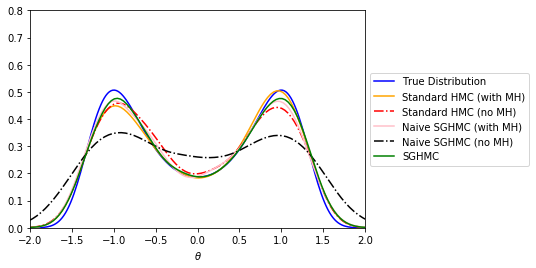

In [39]:
### Figure 1
plt.plot(xs, ys, color = 'blue', label = 'True Distribution')
sns.distplot(theta_hmc_mh1, hist = False, color = 'orange', label = 'Standard HMC (with MH)')
sns.distplot(theta_hmc_nomh1, hist = False, color = 'red', kde_kws={'linestyle':'-.'}, label = 'Standard HMC (no MH)')
sns.distplot(theta_sghmc_naive_mh1, hist = False, color = 'pink', label = 'Naive SGHMC (with MH)')
sns.distplot(theta_sghmc_naive_nomh1, hist = False, color = 'black', kde_kws={'linestyle':'-.'}, label = 'Naive SGHMC (no MH)')
sns.distplot(theta_sghmc1, hist = False, color = 'green', label = 'SGHMC')
plt.axis([-2, 2, 0, 0.8,])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('$\\theta$')
plt.show() #T=15000, m=50

In [32]:
### Figure 2
U2 = lambda x: 1/2*x**2
gradU2 = lambda x: x

theta_init = np.array([0])
M = np.eye(1)
epsilon=0.1
T=300
m=50
V = np.array([4])
C = np.array([3]) 
V_hat = np.array([4])

In [40]:
theta_sghmc, r_sghmc = sghmc(gradU2, theta_init, M , C , V_hat, epsilon, T, m)
theta_hmc, r_hmc = hmc(gradU2, U2, theta_init, M, epsilon, T, m, MH=False)
theta_sghmc_naive_nor, r_sghmc_naive_nor = sghmc_naive(gradU2, U2, theta_init, M, V, epsilon, 1000, m, MH=False, resample=False)
theta_sghmc_naive, r_sghmc_naive = sghmc_naive(gradU2, U2, theta_init, M, V, epsilon, T, m, MH=False, resample=True)

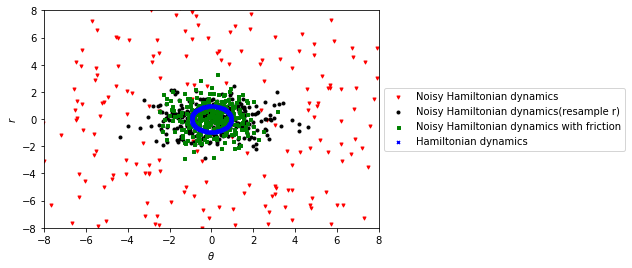

In [46]:
### Figure 2
plt.scatter(theta_sghmc_naive_nor[1000-T:], r_sghmc_naive_nor[1000-T:], color = 'red', marker = 'v', s=9, label = 'Noisy Hamiltonian dynamics')
plt.scatter(theta_sghmc_naive, r_sghmc_naive, color = 'black', marker = 'o', s=9, label = 'Noisy Hamiltonian dynamics(resample r)')
plt.scatter(theta_sghmc, r_sghmc, color = 'green', marker = 's', s=9, label = 'Noisy Hamiltonian dynamics with friction')
plt.scatter(theta_hmc, r_hmc, color = 'blue', marker = 'x', s=9, label = 'Hamiltonian dynamics')
plt.axis([-8, 8, -8, 8,])
plt.xlabel('$\\theta$')
plt.ylabel('$r$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() #T=300, m=50

In [47]:
sigma = np.array([[1, 0.9],[0.9, 1]])
U3 = lambda x: 0.5 * x.T @ np.linalg.inv(sigma) @ x
gradU3 = lambda x: np.linalg.inv(sigma) @ x + np.random.multivariate_normal(np.array([0,0]), np.eye(2))

theta_init = np.array([0,0])
M = np.eye(2)
epsilon=0.1
T=50
m=50
V = V_hat = np.eye(2)
C = 3*np.eye(2)

In [48]:
theta_sghmc3, r_sghmc3 = sghmc(gradU3, theta_init, M , C , V_hat, epsilon, T, m)

In [54]:
theta_hmc_mh3, r_hmc_mh3 = hmc(gradU3, U3, theta_init, M, epsilon, T, m, MH=True, resample=True)

In [56]:
theta_sghmc_naive_mh3, r_sghmc_naive_mh3 = sghmc_naive(gradU3, U3, theta_init, M, V, epsilon, T, m, MH=True, resample=True)

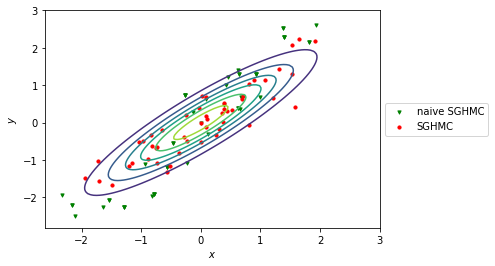

In [63]:
### Figure 3
xs = ys = np.linspace(-2, 3, 100)
x, y = np.meshgrid(xs, ys)
s_inv = np.linalg.inv(sigma)
z = np.exp(-0.5*(s_inv[0,0]*x**2 + 2*s_inv[1,0]*x*y + s_inv[1,1]*y**2))
plt.contour(x, y, z)
#plt.scatter(theta_hmc_mh3[:,0], theta_hmc_mh3[:,1], s = 10, color = 'blue', marker = 'x', label = 'HMC')
plt.scatter(theta_sghmc_naive_mh3[:,0], theta_sghmc_naive_mh3[:,1], s = 10, color = 'green', marker = 'v', label = 'naive SGHMC')
plt.scatter(theta_sghmc3[:,0], theta_sghmc3[:,1], s = 10, color = 'red', marker = 'o', label = 'SGHMC')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

In [83]:
p = 5
true_theta = np.arange(p)
size = 10000
X = np.random.randn(size,p)
y = np.dot(X,true_theta) + np.random.randn(size)
data = np.c_[y,X]

In [84]:
logp_prior_grad = lambda theta: -theta # prior N(0,1)

def logp_data_grad(data, theta):
    """
    log likelihood of a linear regression 
    --------------
    
    Assume that the first column of the data is the predicted variable
    """
    X = data[:,1:]
    y = data[:,0]
    return np.dot(X.T,y) - np.dot(np.dot(X.T,X),theta)

In [85]:
gradU = partial(U_grad_tilde, data=data, logp_data_grad=logp_data_grad, logp_prior_grad=logp_prior_grad, mb_size=1000)
gradU2 = partial(U_grad_tilde, data=data, logp_data_grad=logp_data_grad, logp_prior_grad=logp_prior_grad, mb_size=size)

In [86]:
theta_init = np.zeros(p)
M = np.eye(p)
C = 13*np.eye(p)
V_hat = 0
T = 1000
m = 50
epsilon = 0.0001
theta_sghmc4, r_sghmc4 = sghmc(gradU, theta_init, M, C, V_hat, epsilon, T, m)

In [88]:
theta_sghmc4.mean(axis=0)  ## very close to the true parameters

array([0.00438686, 0.98860674, 1.96770329, 2.97661543, 3.93857378])

In [90]:
theta_hmc4, r_hmc4 = hmc(gradU, U, theta_init, M, epsilon, T, m, MH=False, resample=False)

In [91]:
theta_hmc4.mean(axis=0)  ## performs even better, the reason could be that all observations are independent

array([-2.89326698e-03,  9.99432234e-01,  1.98625050e+00,  2.99924998e+00,
        3.96817053e+00])